In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pymongo
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import TruncatedSVD
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
cat_arg = 'Business_software'

cli = pymongo.MongoClient('52.36.190.91', 27016)

db_ref = cli.semantic_search

co_ref = db_ref['{}'.format(cat_arg)]

In [4]:
bs_df = pd.DataFrame(list(co_ref.find({})))

In [5]:
cat_arg = 'Machine_learning'

cli = pymongo.MongoClient('52.36.190.91', 27016)

db_ref = cli.semantic_search

co_ref = db_ref['{}'.format(cat_arg)]

In [6]:
ml_df = pd.DataFrame(list(co_ref.find({})))

In [7]:
all_df = ml_df.append(bs_df, ignore_index=True)

In [8]:
no_text = all_df[all_df['text']=='']

In [9]:
all_df.drop(list(no_text.index), inplace=True)

In [ ]:
all_df['text'] = all_df['text'].map(lambda x: BeautifulSoup(x, 'html5lib').getText())

In [64]:
all_df.drop('_id', axis=1, inplace=True)

ValueError: labels ['_id'] not contained in axis

In [13]:
all_df.to_pickle('../data/all_df.pkl')

In [4]:
all_df = pd.read_pickle('../data/all_df.pkl')

In [6]:
stop_words = list(ENGLISH_STOP_WORDS)

stop_words.append('reference')

In [9]:
tfidf_vectorizer = TfidfVectorizer(min_df = 1, stop_words = stop_words)

In [10]:
document_term_mat = tfidf_vectorizer.fit_transform(all_df['text'])

In [166]:
# document_term_mat_df = pd.DataFrame(document_term_mat.toarray(),
#                                     columns=tfidf_vectorizer.get_feature_names())

In [11]:
len(tfidf_vectorizer.get_feature_names())

83729

In [168]:
# document_term_mat_df.shape

(5685, 19034)

In [12]:
n_components = 400
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [13]:
svd_matrix = SVD.fit_transform(document_term_mat)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

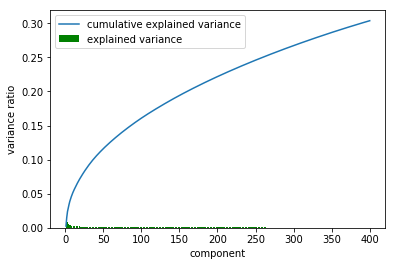

In [15]:
plt.bar(np.array(range(400))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(400))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend()
plt.xlabel('component')
plt.ylabel('variance ratio')

In [23]:
SVD.explained_variance_ratio_

array([ 0.0025284 ,  0.01251754,  0.00878407,  0.00523577,  0.0050569 ,
        0.0045741 ,  0.00364638,  0.00327676,  0.00309905,  0.00278467,
        0.00263336,  0.00237582,  0.00233392,  0.00226633,  0.00222623,
        0.00215711,  0.00207947,  0.0020443 ,  0.00195494,  0.00188895,
        0.00185248,  0.00180922,  0.00179045,  0.0017668 ,  0.00169854,
        0.00167167,  0.00162279,  0.00161999,  0.00158407,  0.00154803,
        0.00153707,  0.00146556,  0.00144717,  0.00144555,  0.0014223 ,
        0.0013832 ,  0.00133914,  0.00131744,  0.0012927 ,  0.00126968,
        0.00122719,  0.00122139,  0.00120896,  0.00118954,  0.00116953,
        0.00115348,  0.00114274,  0.0011326 ,  0.00112504,  0.00110163,
        0.00110013,  0.00107689,  0.00105712,  0.00104697,  0.00103979,
        0.00103578,  0.00102649,  0.00101429,  0.00101156,  0.00099919,
        0.00099243,  0.000978  ,  0.0009688 ,  0.00096258,  0.00095325,
        0.00095141,  0.00094303,  0.00093728,  0.00092011,  0.00

In [16]:
svd_matrix[:4]

array([[  1.39620057e-01,   1.77671339e-02,  -1.34938034e-02, ...,
          1.56196059e-03,  -3.11548895e-03,  -8.85251322e-03],
       [  1.67134475e-01,   4.10857419e-01,   2.62303645e-02, ...,
         -1.02974771e-02,   1.31690889e-02,  -4.16074233e-03],
       [  2.52060625e-01,   6.87199596e-01,   3.77294820e-02, ...,
         -1.74411713e-04,   8.07581902e-03,  -1.00906369e-02],
       [  1.51519953e-01,   1.59228111e-01,  -8.97701824e-03, ...,
          2.66083454e-02,   2.52208272e-03,  -1.28840980e-02]])

In [17]:
all_df.head()

,category,page,text,title
0,Machine learning,Geoffrey_Hinton,Geoffrey Everest Hinton FRS (born 6 December 1...,Geoffrey Hinton
1,Machine learning,Reward-based_selection,Reward-based selection is a technique used in ...,Reward-based selection
3,Machine learning,Cross_entropy,"In information theory, the cross entropy betwe...",Cross entropy
4,Machine learning,Cluster-weighted_modeling,"In data mining, cluster-weighted modeling (CWM...",Cluster-weighted modeling
5,Machine learning,Cultural_algorithm,Cultural algorithms (CA) are a branch of evolu...,Cultural algorithm


In [18]:
lsa_df = pd.DataFrame(svd_matrix,
                      columns=component_names)

In [19]:
lsa_df.insert(0, 'page', all_df.page)

In [20]:
lsa_df.insert(0, 'category', all_df.category)

In [21]:
lsa_df.set_index('page', inplace=True)

In [22]:
vocabulary_loadings = pd.DataFrame(SVD.components_,
                                   index=component_names,
                                   columns=tfidf_vectorizer.get_feature_names()).T

In [23]:
vocabulary_loadings['abs_component_1'] = np.abs(vocabulary_loadings.component_1)
vocabulary_loadings['abs_component_2'] = np.abs(vocabulary_loadings.component_2)

In [24]:
vocabulary_loadings.sort_values('abs_component_1',ascending=False).head(50)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,component_400,abs_component_1,abs_component_2
displaystyle,0.229689,0.764432,0.050053,0.243487,-0.016488,-0.270784,-0.003691,0.020033,0.022227,0.062434,...,0.007448,0.006101,-0.001990,0.003962,0.002727,0.007353,0.003045,-0.005153,0.229689,0.764432
software,0.169530,-0.091184,-0.092156,0.030728,-0.181818,-0.090456,-0.030369,-0.109049,-0.074093,0.228656,...,0.007368,0.009391,-0.000493,-0.021475,0.000350,-0.004007,-0.000611,0.007167,0.169530,0.091184
game,0.160526,-0.111492,0.717332,0.011000,0.020888,-0.019830,-0.057421,0.008967,-0.054420,-0.028899,...,0.005796,-0.003636,-0.001641,0.004810,0.010011,0.007244,-0.007539,-0.001842,0.160526,0.111492
data,0.149046,0.022874,-0.066718,-0.129864,-0.057950,0.110211,0.031510,0.102448,-0.093049,-0.211146,...,-0.001208,0.012778,0.006156,0.006559,0.004507,0.001453,0.007512,0.012502,0.149046,0.022874
management,0.148853,-0.086798,-0.067060,-0.021187,-0.255036,-0.173656,-0.096259,-0.094207,-0.257244,0.154762,...,0.000861,-0.003262,0.006965,0.004990,-0.017160,0.007512,-0.011634,0.005548,0.148853,0.086798
search,0.124736,-0.037744,-0.086230,-0.278526,0.617834,-0.311810,0.116868,-0.097957,-0.209964,-0.011886,...,0.000654,0.006261,-0.000398,0.007499,0.011465,-0.006302,0.004318,0.006072,0.124736,0.037744
microsoft,0.105856,-0.068633,-0.057963,0.338574,0.080814,0.157867,0.220319,-0.101781,-0.101696,-0.044407,...,-0.015038,0.037083,-0.000131,-0.009331,0.001258,-0.004802,0.011045,-0.006208,0.105856,0.068633
web,0.104015,-0.055227,-0.071354,0.006204,0.092297,-0.070470,-0.133471,0.012834,0.035942,-0.014422,...,-0.011517,0.013944,0.000236,-0.001444,-0.000892,0.023720,-0.008871,0.007593,0.104015,0.055227
learning,0.099931,0.116915,-0.009358,-0.230018,-0.011473,0.312666,0.059786,-0.149185,0.088004,0.155916,...,0.013443,-0.007049,0.014362,0.007343,0.012869,0.003132,-0.008592,-0.001198,0.099931,0.116915
project,0.097060,-0.054506,-0.055666,0.038822,-0.084141,-0.035519,-0.156938,-0.064611,-0.093727,0.372895,...,0.004598,-0.004888,-0.009768,-0.010629,0.004985,-0.003363,0.007531,0.011350,0.097060,0.054506


In [25]:
vocabulary_loadings.sort_values('abs_component_2',ascending=False).head(50)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,component_400,abs_component_1,abs_component_2
displaystyle,0.229689,0.764432,0.050053,0.243487,-0.016488,-0.270784,-0.003691,0.020033,0.022227,0.062434,...,0.007448,0.006101,-0.001990,0.003962,0.002727,0.007353,0.003045,-0.005153,0.229689,0.764432
x_,0.044751,0.144959,0.008891,0.038845,-0.003567,-0.041571,-0.000271,-0.001497,0.006469,0.011122,...,-0.012527,0.014038,-0.017433,0.007058,-0.005452,-0.009044,0.007462,-0.007409,0.044751,0.144959
mathbf,0.039261,0.133001,0.008922,0.047224,-0.003648,-0.052135,-0.006009,0.002832,0.007117,0.004536,...,-0.001148,0.004870,-0.000278,-0.001512,-0.001652,-0.006683,0.000693,0.002516,0.039261,0.133001
learning,0.099931,0.116915,-0.009358,-0.230018,-0.011473,0.312666,0.059786,-0.149185,0.088004,0.155916,...,0.013443,-0.007049,0.014362,0.007343,0.012869,0.003132,-0.008592,-0.001198,0.099931,0.116915
game,0.160526,-0.111492,0.717332,0.011000,0.020888,-0.019830,-0.057421,0.008967,-0.054420,-0.028899,...,0.005796,-0.003636,-0.001641,0.004810,0.010011,0.007244,-0.007539,-0.001842,0.160526,0.111492
algorithm,0.059929,0.106166,-0.002219,-0.072410,0.021678,0.078613,0.013684,-0.031487,-0.006523,-0.034462,...,-0.002823,0.009697,-0.007148,-0.000753,0.008542,-0.004748,-0.011856,-0.015815,0.059929,0.106166
software,0.169530,-0.091184,-0.092156,0.030728,-0.181818,-0.090456,-0.030369,-0.109049,-0.074093,0.228656,...,0.007368,0.009391,-0.000493,-0.021475,0.000350,-0.004007,-0.000611,0.007167,0.169530,0.091184
management,0.148853,-0.086798,-0.067060,-0.021187,-0.255036,-0.173656,-0.096259,-0.094207,-0.257244,0.154762,...,0.000861,-0.003262,0.006965,0.004990,-0.017160,0.007512,-0.011634,0.005548,0.148853,0.086798
function,0.045029,0.079449,-0.000588,-0.018913,0.001200,0.040219,-0.002016,-0.017562,0.006812,-0.006949,...,0.006750,-0.001692,0.011047,0.018176,-0.030178,0.000130,-0.017773,0.021703,0.045029,0.079449
sum,0.027864,0.078923,0.004874,0.015260,-0.000548,-0.012768,0.000837,0.000479,0.002820,-0.000771,...,-0.001872,-0.016803,0.003831,-0.015246,-0.004415,-0.008449,0.004243,0.011330,0.027864,0.078923


In [26]:
import pickle

In [ ]:
pickle.dump(tfidf_vectorizer, open('../data/tfidf_vectorizer.pkl', 'wb'))
pickle.dump(SVD, open('../data/SVD.pkl', 'wb'))
pickle.dump(svd_matrix, open('../data/svd_matrix.pkl', 'wb'))
lsa_df.to_pickle('../data/lsa_df.pkl')